
# 🛡️ Антифрод — Финальная клиентская тетрадь (E2E)
**Версия:** 1.0 

---
**Содержание**
1. Подготовка окружения  
2. Конфигурация / параметры запуска  
3. Загрузка данных (fastparquet/CSV)  
4. Качественный контроль данных (DQA)  
5. Обзор набора (EDA, графики)  
6. Фича-инжиниринг (быстрый и расширенный режим)  
7. Модель логистической регрессии (Pipeline)  
8. Метрики качества (ROC-AUC, PR, Confusion)  
9. Экономический эффект и подбор порога  
10. Итоговое резюме и артефакты  
11. Приложение: Справочник полей, доп. проверки


## 1) Подготовка окружения

In [60]:
import sys
import subprocess
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

req_file = Path("requirements.txt")
if req_file.exists():
    print("📦 Устанавливаем зависимости из requirements.txt...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", "requirements.txt", "--quiet"])
    print("✅ Все зависимости установлены")
else:
    print("⚠️ requirements.txt не найден, устанавливаем основные библиотеки...")
    packages = ["pandas", "numpy", "scikit-learn", "matplotlib", "seaborn", "fastparquet", "joblib"]
    for pkg in packages:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "--quiet"])
    print("✅ Основные библиотеки установлены")


📦 Устанавливаем зависимости из requirements.txt...
✅ Все зависимости установлены


## 2) Импорты и общие настройки

In [61]:

import os
import json
import math
from pathlib import Path
from dataclasses import dataclass
import numpy as np
import pandas as pd
from datetime import datetime

# Графики — matplotlib + seaborn для более красивых визуализаций
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# Настройка стиля seaborn для делового вида
sns.set_style("whitegrid")
# Деловая цветовая палитра: синие, серые, приглушенные тона
business_colors = ['#2E86C1', '#566573', '#48C9B0', '#F39C12', '#E74C3C', '#8E44AD', '#27AE60']
sns.set_palette(business_colors)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 10

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix,
    classification_report, accuracy_score, precision_score, recall_score
)
from sklearn.utils import shuffle
import joblib

from IPython.display import Markdown, display

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)
pd.set_option("display.float_format", lambda v: f"{v:,.2f}")
print("🚀 Импорты выполнены")


🚀 Импорты выполнены


## 3) Конфигурация / параметры запуска

In [62]:

# === ПУТИ К ДАННЫМ ===
# Поддерживаются .parquet (через fastparquet) и .csv
DATA_PATH = "transaction_fraud_data.parquet"   # или "data/transactions.csv"
FX_PATH   = "historical_currency_exchange.parquet"       # опционально: курсы валют .parquet/.csv, можно оставить None
DATE_COL  = "timestamp"                    # имя колонки с датой/временем транзакции
TARGET    = "is_fraud"                     # 0/1 или True/False

# Кандидаты для автоматического маппинга колонок (переименуем в стандартизированные имена)
CANDIDATES = {
    "amount": ["amount", "amt", "transaction_amount"],
    "customer_id": ["customer_id", "client_id", "user_id", "account_id"],
    "merchant_id": ["merchant_id", "vendor_id", "seller_id"],
    "country": ["country", "customer_country"],
    "currency": ["currency", "ccy"],
    "card_type": ["card_type", "card_product"],
    "device": ["device", "device_type"],
    "channel": ["channel", "txn_channel", "pos_channel"],
    "is_card_present": ["is_card_present", "card_present"],
    "is_outside_home_country": ["is_outside_home_country", "is_international", "outside_home_country"],
    "vendor_category": ["vendor_category", "merchant_category", "mcc_group"]
}

# === РЕЖИМЫ И ПРОЧЕЕ ===
SAMPLE_FRAC = 1.0          # 1.0 = весь набор; для быстрой пробы можно 0.1
RANDOM_STATE = 42
FAST_FEATURES_ONLY = True   # True: только лёгкие фичи; False: добавит более тяжёлые оконные аггрегаты
TOP_CAT_MIN_FREQ = 0.01     # доля для автоматического объединения редких категорий в 'Other' (OneHotEncoder)

# Экономическая модель
FP_COST = 5.0               # условная "стоимость" ложноположительного (доп. проверка, трение клиента), валюта исходных сумм
PREVENTED_FRAUD_RATE = 0.8  # доля предотвращаемого ущерба у верно пойманных мошеннич. транзакций

# Визуализация
FIGSIZE = (10, 6)
FIGSIZE_LARGE = (12, 8)

print("⚙️ Параметры заданы. Отредактируйте при необходимости и выполните повторно.")


⚙️ Параметры заданы. Отредактируйте при необходимости и выполните повторно.


## 4) Вспомогательные функции

In [63]:

def _choose_column(df, names):
    for n in names:
        if n in df.columns:
            return n
    return None

def _read_any(path: str):
    if path is None or not Path(path).exists():
        return None
    ext = Path(path).suffix.lower()
    if ext == ".parquet":
        return pd.read_parquet(path, engine="fastparquet")
    elif ext == ".csv":
        return pd.read_csv(path)
    else:
        raise ValueError(f"Неподдерживаемое расширение файла: {ext}")

def _rename_columns(df):
    mapping = {}
    for std_name, options in CANDIDATES.items():
        col = _choose_column(df, options)
        if col and col != std_name:
            mapping[col] = std_name
    if TARGET in df.columns:
        mapping[TARGET] = "is_fraud"  # на всякий случай выровняем
    if DATE_COL in df.columns:
        mapping[DATE_COL] = "timestamp"
    df = df.rename(columns=mapping)
    return df

def _fmt_money(x, pos):
    try:
        return f"${x:,.0f}"
    except Exception:
        return str(x)

def show_md(s):
    display(Markdown(s))

print("🔧 Вспомогательные функции готовы")


🔧 Вспомогательные функции готовы


## 5) Загрузка данных

In [64]:

df = _read_any(DATA_PATH)
assert df is not None, "Не найден DATA_PATH. Укажите корректный путь к данным."
df = _rename_columns(df).copy()

# Унификация типа целевой переменной
if "is_fraud" not in df.columns:
    raise ValueError("Не найдена колонка целевой переменной (is_fraud/TARGET). Проверьте конфигурацию.")
if df["is_fraud"].dtype != "int64" and df["is_fraud"].dtype != "int32":
    df["is_fraud"] = df["is_fraud"].astype("int32")

# Преобразуем дату/время
if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    if df["timestamp"].isna().all():
        raise ValueError("Колонка времени 'timestamp' не может быть распознана как datetime.")
else:
    raise ValueError("Не найдена колонка времени. Укажите DATE_COL корректно.")

# Уберём явные дубликаты строк, если есть идентификатор транзакции — замените 'txn_id' на актуальный
if "txn_id" in df.columns:
    before = len(df)
    df = df.drop_duplicates("txn_id")
    print(f"🧹 Убрано дубликатов по txn_id: {before - len(df):,}")

# Сэмплирование (опционально)
if 0 < SAMPLE_FRAC < 1.0:
    df = df.sample(frac=SAMPLE_FRAC, random_state=RANDOM_STATE).sort_values("timestamp")

print(f"✅ Загружено строк: {len(df):,}; колонок: {df.shape[1]}")
print("Доступные столбцы:", list(df.columns))


✅ Загружено строк: 7,483,766; колонок: 27
Доступные столбцы: ['transaction_id', 'customer_id', 'card_number', 'timestamp', 'vendor_category', 'vendor_type', 'vendor', 'amount', 'currency', 'country', 'city', 'city_size', 'card_type', 'is_card_present', 'device', 'channel', 'device_fingerprint', 'ip_address', 'is_outside_home_country', 'is_high_risk_vendor', 'is_weekend', 'is_fraud', 'last_hour_activity.num_transactions', 'last_hour_activity.total_amount', 'last_hour_activity.unique_merchants', 'last_hour_activity.unique_countries', 'last_hour_activity.max_single_amount']


## 6) Качественный контроль данных (DQA)

In [65]:

missing = df.isna().mean().sort_values(ascending=False).to_frame("missing_share")
dups_total = df.duplicated().sum()

amount_col = _choose_column(df, ["amount"])
neg_amounts = int((df[amount_col] < 0).sum()) if amount_col else 0

show_md("### Итоги контроля качества")
print("• Период данных:", df["timestamp"].min(), "→", df["timestamp"].max())
print("• Доля пропусков (top-10):")
display(missing.head(10))
print(f"• Дубликатов строк: {dups_total:,}")
if amount_col:
    print(f"• Отрицательных сумм: {neg_amounts:,}")

# Статистика по таргету
vc = df["is_fraud"].value_counts()
fraud_rate = vc.get(1, 0) / vc.sum()
print(f"• Уровень мошенничества: {fraud_rate:.2%}  ({vc.get(1,0):,} / {vc.sum():,})")


### Итоги контроля качества

• Период данных: 2024-09-30 00:00:01.034820 → 2024-10-30 23:59:59.101885
• Доля пропусков (top-10):


,missing_share
transaction_id,0.00
device,0.00
last_hour_activity.unique_countries,0.00
last_hour_activity.unique_merchants,0.00
last_hour_activity.total_amount,0.00
last_hour_activity.num_transactions,0.00
is_fraud,0.00
is_weekend,0.00
is_high_risk_vendor,0.00
is_outside_home_country,0.00


• Дубликатов строк: 0
• Отрицательных сумм: 0
• Уровень мошенничества: 19.97%  (1,494,719 / 7,483,766)


## 7) Обзор набора (EDA)

### Ключевые размеры датасета

Размерность: (7483766, 27)
Период: 2024-09-30 00:00:01.034820 → 2024-10-30 23:59:59.101885
Уникальных клиентов: 4,869
Стран: 12
Валют: 11


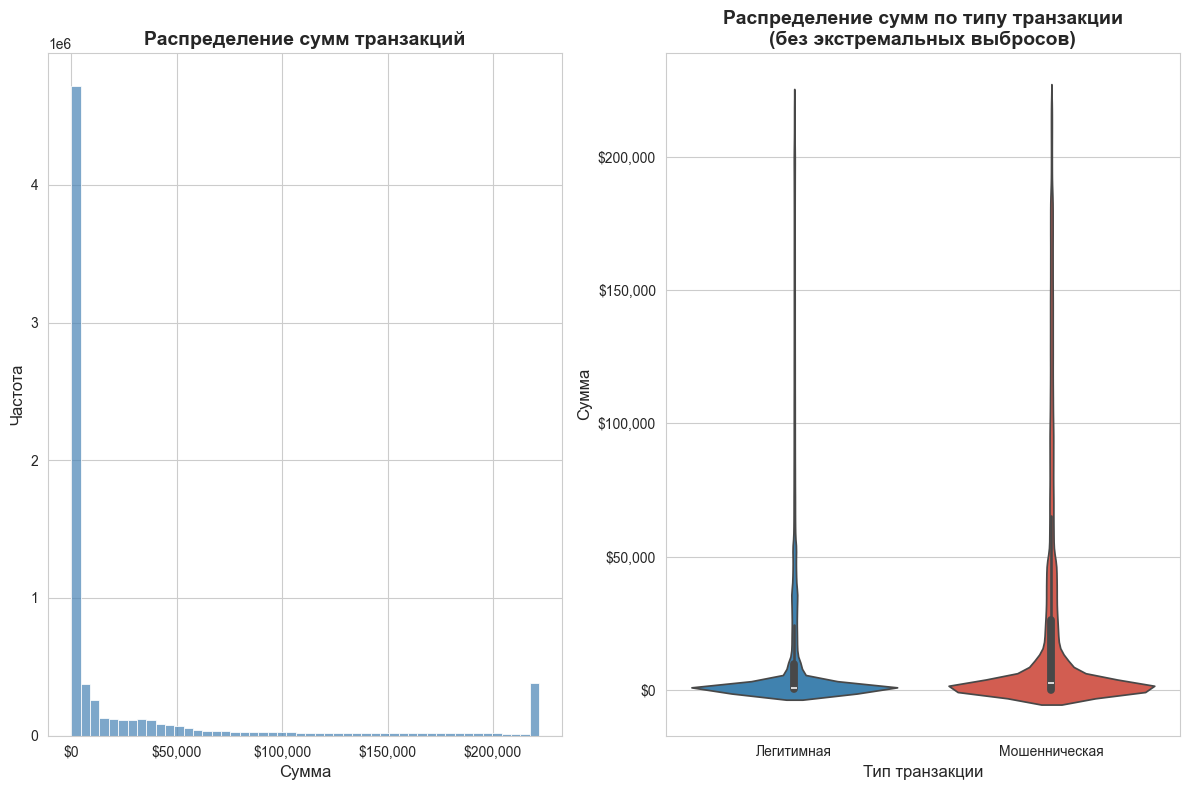

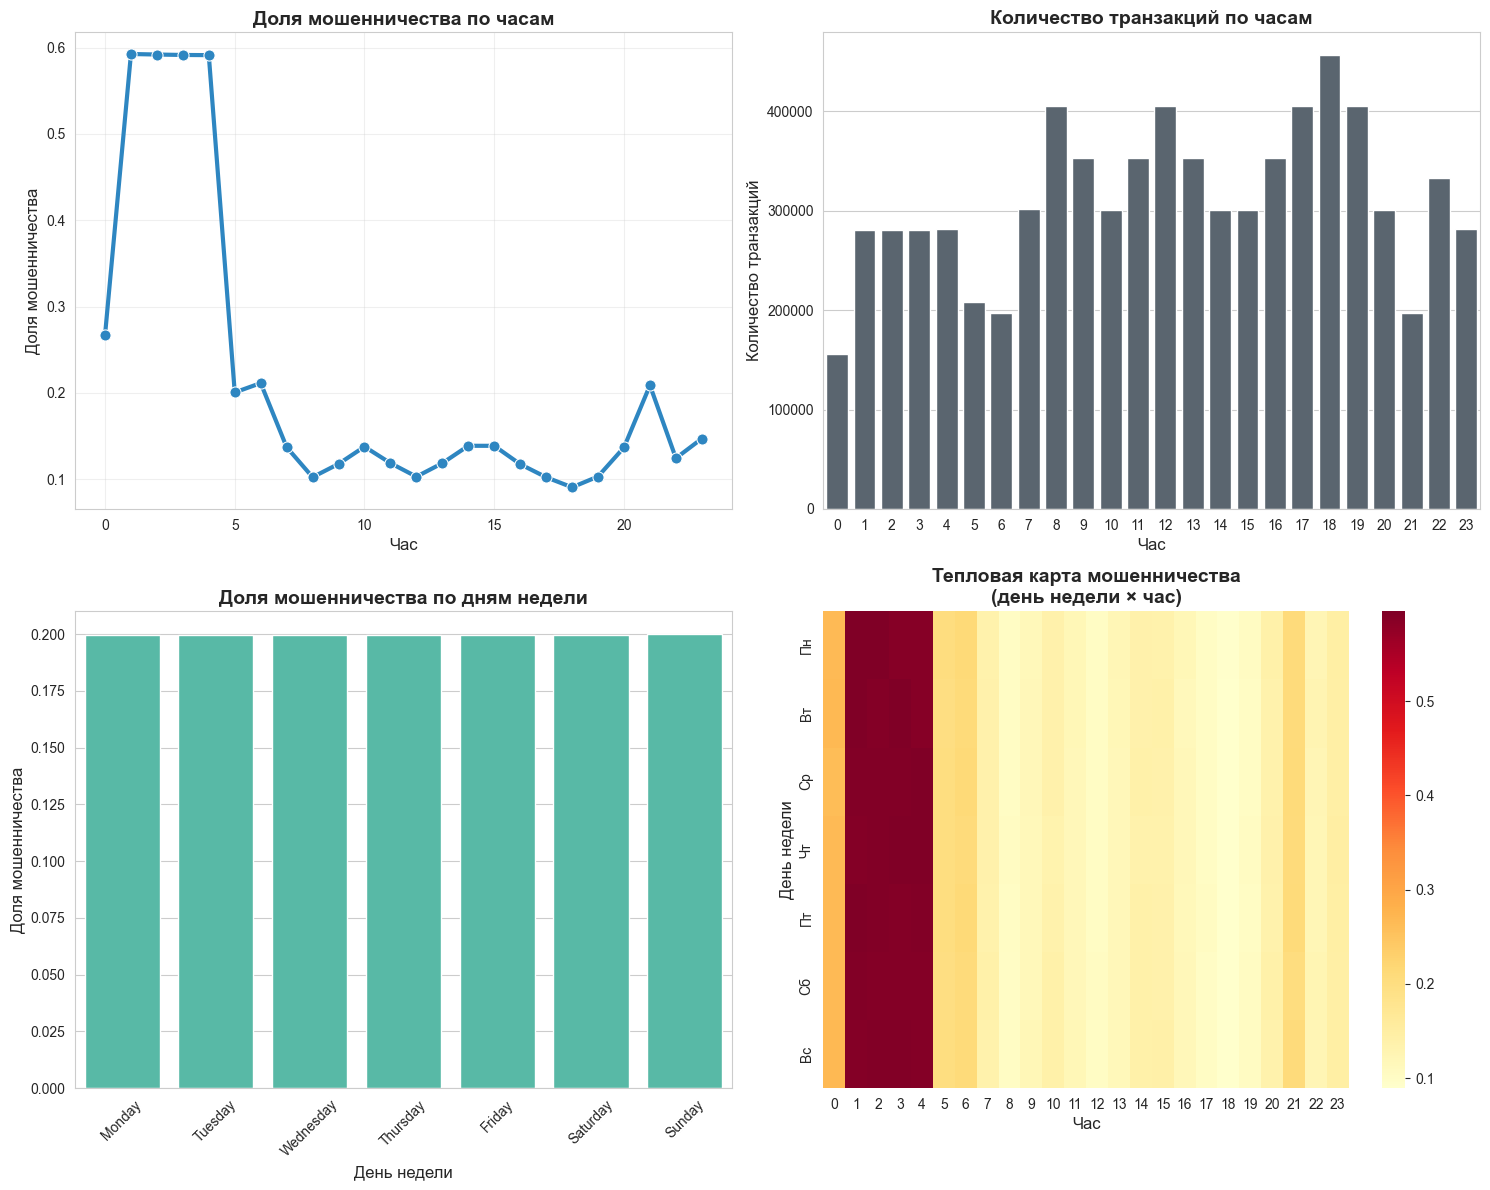

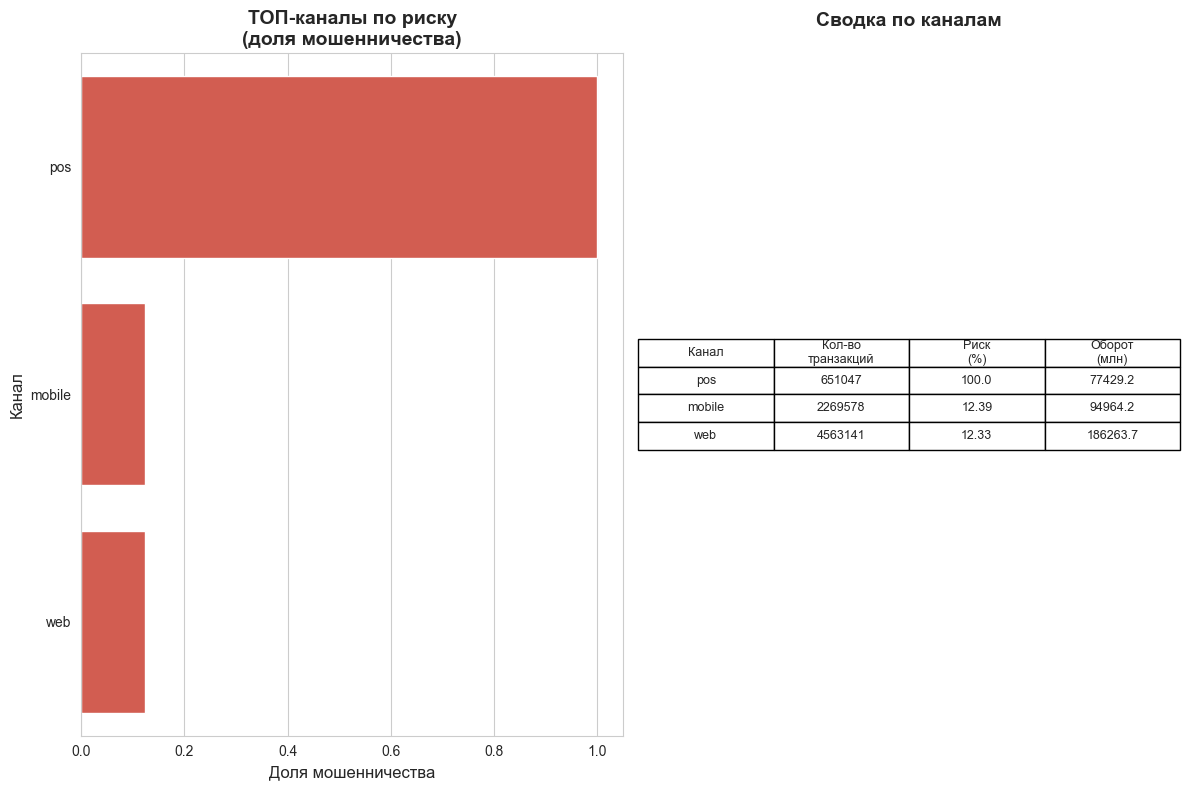

In [66]:

customer_col = _choose_column(df, ["customer_id"])
merchant_col = _choose_column(df, ["merchant_id"])
country_col  = _choose_column(df, ["country"])
currency_col = _choose_column(df, ["currency"])
channel_col  = _choose_column(df, ["channel"])
device_col   = _choose_column(df, ["device"])
cardtype_col = _choose_column(df, ["card_type"])

n_customers = df[customer_col].nunique() if customer_col else None
n_merchants = df[merchant_col].nunique() if merchant_col else None
n_countries = df[country_col].nunique() if country_col else None
n_currencies = df[currency_col].nunique() if currency_col else None

show_md("### Ключевые размеры датасета")
print("Размерность:", df.shape)
print("Период:", df['timestamp'].min(), "→", df['timestamp'].max())
if n_customers is not None: print("Уникальных клиентов:", f"{n_customers:,}")
if n_merchants is not None: print("Уникальных продавцов:", f"{n_merchants:,}")
if n_countries  is not None: print("Стран:", n_countries)
if n_currencies is not None: print("Валют:", n_currencies)

amount_col = _choose_column(df, ["amount"])
if amount_col:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=FIGSIZE_LARGE)
    
    # Гистограмма распределения сумм
    amounts_clean = df[amount_col].clip(lower=0, upper=df[amount_col].quantile(0.95))  # убираем выбросы для лучшей визуализации
    sns.histplot(data=df, x=amounts_clean, bins=50, ax=ax1, color='steelblue', alpha=0.7)
    ax1.set_title("Распределение сумм транзакций", fontsize=14, fontweight='bold')
    ax1.set_xlabel("Сумма", fontsize=12)
    ax1.set_ylabel("Частота", fontsize=12)
    ax1.xaxis.set_major_formatter(FuncFormatter(_fmt_money))
    
    # Violin plot сумм по типу транзакции (убираем выбросы для лучшей читаемости)
    df_plot = df[[amount_col, 'is_fraud']].copy()
    # Убираем экстремальные выбросы (>95 перцентиль)
    q95 = df_plot[amount_col].quantile(0.95)
    df_plot_clean = df_plot[df_plot[amount_col] <= q95].copy()
    df_plot_clean['Тип транзакции'] = df_plot_clean['is_fraud'].map({0: 'Легитимная', 1: 'Мошенническая'})
    
    sns.violinplot(data=df_plot_clean, x='Тип транзакции', y=amount_col, ax=ax2, palette=['#2E86C1', '#E74C3C'])
    ax2.set_title("Распределение сумм по типу транзакции\n(без экстремальных выбросов)", fontsize=14, fontweight='bold')
    ax2.set_xlabel("Тип транзакции", fontsize=12)
    ax2.set_ylabel("Сумма", fontsize=12)
    ax2.yaxis.set_major_formatter(FuncFormatter(_fmt_money))
    
    plt.tight_layout()
    plt.show()

# Временные паттерны
df["hour"] = df["timestamp"].dt.hour
df["day_name"] = df["timestamp"].dt.day_name()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Доля мошенничества по часам
fraud_by_hour = df.groupby("hour")["is_fraud"].mean()
sns.lineplot(x=fraud_by_hour.index, y=fraud_by_hour.values, marker="o", ax=ax1, linewidth=3, markersize=8)
ax1.set_title("Доля мошенничества по часам", fontsize=14, fontweight='bold')
ax1.set_xlabel("Час", fontsize=12)
ax1.set_ylabel("Доля мошенничества", fontsize=12)
ax1.grid(True, alpha=0.3)

# 2. Количество транзакций по часам
txn_by_hour = df.groupby("hour").size()
sns.barplot(x=txn_by_hour.index, y=txn_by_hour.values, ax=ax2, color='#566573')
ax2.set_title("Количество транзакций по часам", fontsize=14, fontweight='bold')
ax2.set_xlabel("Час", fontsize=12)
ax2.set_ylabel("Количество транзакций", fontsize=12)

# 3. Доля мошенничества по дням недели
fraud_by_day = df.groupby("day_name")["is_fraud"].mean()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fraud_by_day = fraud_by_day.reindex(day_order)
sns.barplot(x=fraud_by_day.index, y=fraud_by_day.values, ax=ax3, color='#48C9B0')
ax3.set_title("Доля мошенничества по дням недели", fontsize=14, fontweight='bold')
ax3.set_xlabel("День недели", fontsize=12)
ax3.set_ylabel("Доля мошенничества", fontsize=12)
ax3.tick_params(axis='x', rotation=45)

# 4. Heatmap мошенничества по часам и дням недели
df['day_num'] = df['timestamp'].dt.dayofweek
heatmap_data = df.groupby(['day_num', 'hour'])['is_fraud'].mean().unstack()
sns.heatmap(heatmap_data, ax=ax4, cmap='YlOrRd', annot=False, fmt='.3f', 
           yticklabels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
ax4.set_title("Тепловая карта мошенничества\n(день недели × час)", fontsize=14, fontweight='bold')
ax4.set_xlabel("Час", fontsize=12)
ax4.set_ylabel("День недели", fontsize=12)

plt.tight_layout()
plt.show()

if channel_col:
    # Анализ каналов
    channel_stats = df.groupby(channel_col).agg({
        'is_fraud': ['mean', 'count'],
        amount_col: 'sum' if amount_col else 'count'
    }).round(4)
    channel_stats.columns = ['fraud_rate', 'total_txns', 'total_amount']
    channel_stats = channel_stats[channel_stats['total_txns'] >= 100].sort_values('fraud_rate', ascending=False)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=FIGSIZE_LARGE)
    
    # Доля мошенничества по каналам
    top_channels = channel_stats.head(10)
    colors = ['#E74C3C' if x > 0.05 else '#2E86C1' for x in top_channels['fraud_rate']]
    sns.barplot(data=top_channels.reset_index(), x='fraud_rate', y=channel_col, ax=ax1, 
               palette=colors, orient='h')
    ax1.set_title("ТОП-каналы по риску\n(доля мошенничества)", fontsize=14, fontweight='bold')
    ax1.set_xlabel("Доля мошенничества", fontsize=12)
    ax1.set_ylabel("Канал", fontsize=12)
    
    # Таблица каналов вместо непонятного scatter plot
    channel_summary = channel_stats.head(8).reset_index()
    channel_summary['fraud_rate_pct'] = (channel_summary['fraud_rate'] * 100).round(2)
    channel_summary['total_amount_m'] = (channel_summary['total_amount'] / 1000000).round(1)
    
    # Создаем таблицу
    ax2.axis('tight')
    ax2.axis('off')
    table_data = channel_summary[[channel_col, 'total_txns', 'fraud_rate_pct', 'total_amount_m']].values
    table = ax2.table(cellText=table_data,
                     colLabels=['Канал', 'Кол-во\nтранзакций', 'Риск\n(%)', 'Оборот\n(млн)'],
                     cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)
    ax2.set_title("Сводка по каналам", fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()


## 8) Фича-инжиниринг

In [67]:

df = df.sort_values(["timestamp"]).copy()

# Базовые календарные фичи
df["is_weekend"] = df["timestamp"].dt.weekday.isin([5, 6]).astype(int)
df["is_night"]   = df["timestamp"].dt.hour.isin([0,1,2,3,4]).astype(int)
df["day_of_week"]= df["timestamp"].dt.weekday

# Булевы признаки, если есть
for col in ["is_card_present", "is_outside_home_country"]:
    if col in df.columns and df[col].dtype != "int64":
        df[col] = df[col].astype("int8")

# Лёгкие агрегации (по клиенту и дню)
customer_col = _choose_column(df, ["customer_id"])
merchant_col = _choose_column(df, ["merchant_id"])
country_col  = _choose_column(df, ["country"])

amount_col = _choose_column(df, ["amount"])
if amount_col is None:
    raise ValueError("Не найдена колонка суммы. Добавьте название в CANDIDATES['amount'].")

if FAST_FEATURES_ONLY:
    # Дневные аггрегаты по клиенту
    df["date"] = df["timestamp"].dt.date
    grp_day = df.groupby([customer_col, "date"])
    daily_stats = grp_day[amount_col].agg(
        num_transactions="count",
        total_amount="sum",
        max_single_amount="max",
    ).reset_index()
    # Уникальные продавцы/страны за день
    daily_unique = grp_day.agg(
        unique_merchants=(merchant_col, "nunique") if merchant_col else (customer_col, "size"),
        unique_countries=(country_col, "nunique") if country_col else (customer_col, "size"),
    ).reset_index()
    daily = pd.merge(daily_stats, daily_unique, on=[customer_col, "date"], how="left")
    df = pd.merge(df, daily, on=[customer_col, "date"], how="left")
    df = df.drop(columns=["date"])
else:
    # Расширенные «скользящие» окна за 24 часа (дороже по ресурсам)
    # Для больших датасетов рекомендуется кластерное исполнение/Spark
    df = df.sort_values([customer_col, "timestamp"])
    def rolling_last_24h(group):
        g = group.set_index("timestamp").sort_index()
        r = g[amount_col].rolling("1D")
        group["num_transactions"] = r.count().values
        group["total_amount"] = r.sum().values
        group["max_single_amount"] = r.max().values
        if merchant_col:
            group["unique_merchants"] = g[merchant_col].rolling("1D").apply(lambda s: s.nunique(), raw=False).values
        else:
            group["unique_merchants"] = 1
        if country_col:
            group["unique_countries"] = g[country_col].rolling("1D").apply(lambda s: s.nunique(), raw=False).values
        else:
            group["unique_countries"] = 1
        return group.reset_index(drop=True)
    df = df.groupby(customer_col, group_keys=False).apply(rolling_last_24h)

# Категориальные признаки
vendor_category_col = _choose_column(df, ["vendor_category"])
currency_col = _choose_column(df, ["currency"])
cardtype_col = _choose_column(df, ["card_type"])
device_col = _choose_column(df, ["device"])
channel_col = _choose_column(df, ["channel"])

CATS = [c for c in [vendor_category_col, country_col, currency_col, cardtype_col, device_col, channel_col] if c]
NUMS = [c for c in ["amount","is_card_present","is_outside_home_country","is_weekend","is_night","hour","day_of_week",
                    "num_transactions","total_amount","unique_merchants","unique_countries","max_single_amount"]
        if c in df.columns]

print("Числовые признаки:", NUMS)
print("Категориальные признаки:", CATS)

feature_cols = NUMS + CATS
df_model = df.dropna(subset=[TARGET] + feature_cols).copy()
print("Размер данных для модели:", df_model.shape)


Числовые признаки: ['amount', 'is_card_present', 'is_outside_home_country', 'is_weekend', 'is_night', 'hour', 'day_of_week', 'num_transactions', 'total_amount', 'unique_merchants', 'unique_countries', 'max_single_amount']
Категориальные признаки: ['vendor_category', 'country', 'currency', 'card_type', 'device', 'channel']
Размер данных для модели: (7483766, 37)


## 9) Обучение модели (Logistic Regression Pipeline)

In [68]:

X = df_model[feature_cols]
y = df_model["is_fraud"]

# Подготовка трансформера
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="infrequent_if_exist", min_frequency=TOP_CAT_MIN_FREQ), CATS),
        ("num", StandardScaler(), NUMS),
    ],
    remainder="drop"
)

clf = LogisticRegression(
    max_iter=500,
    class_weight="balanced",
    n_jobs=None,   # у LogisticRegression нет n_jobs в sklearn<1.6; оставим None для совместимости
    solver="lbfgs"
)

pipe = make_pipeline(preprocess, clf)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Обучение...")
pipe.fit(X_train, y_train)
print("Готово.")

# Метрики
proba_test = pipe.predict_proba(X_test)[:, 1]
pred_test_default = (proba_test >= 0.5).astype(int)

roc = roc_auc_score(y_test, proba_test)
acc = accuracy_score(y_test, pred_test_default)
prec = precision_score(y_test, pred_test_default, zero_division=0)
rec = recall_score(y_test, pred_test_default, zero_division=0)

print(f"ROC-AUC: {roc:.4f}")
print(f"Accuracy @0.5: {acc:.4f}")
print(f"Precision @0.5: {prec:.4f}")
print(f"Recall @0.5: {rec:.4f}")


Обучение...
Готово.
ROC-AUC: 0.9710
Accuracy @0.5: 0.9245
Precision @0.5: 0.7636
Recall @0.5: 0.9011


## 10) Кривые ROC и Precision–Recall

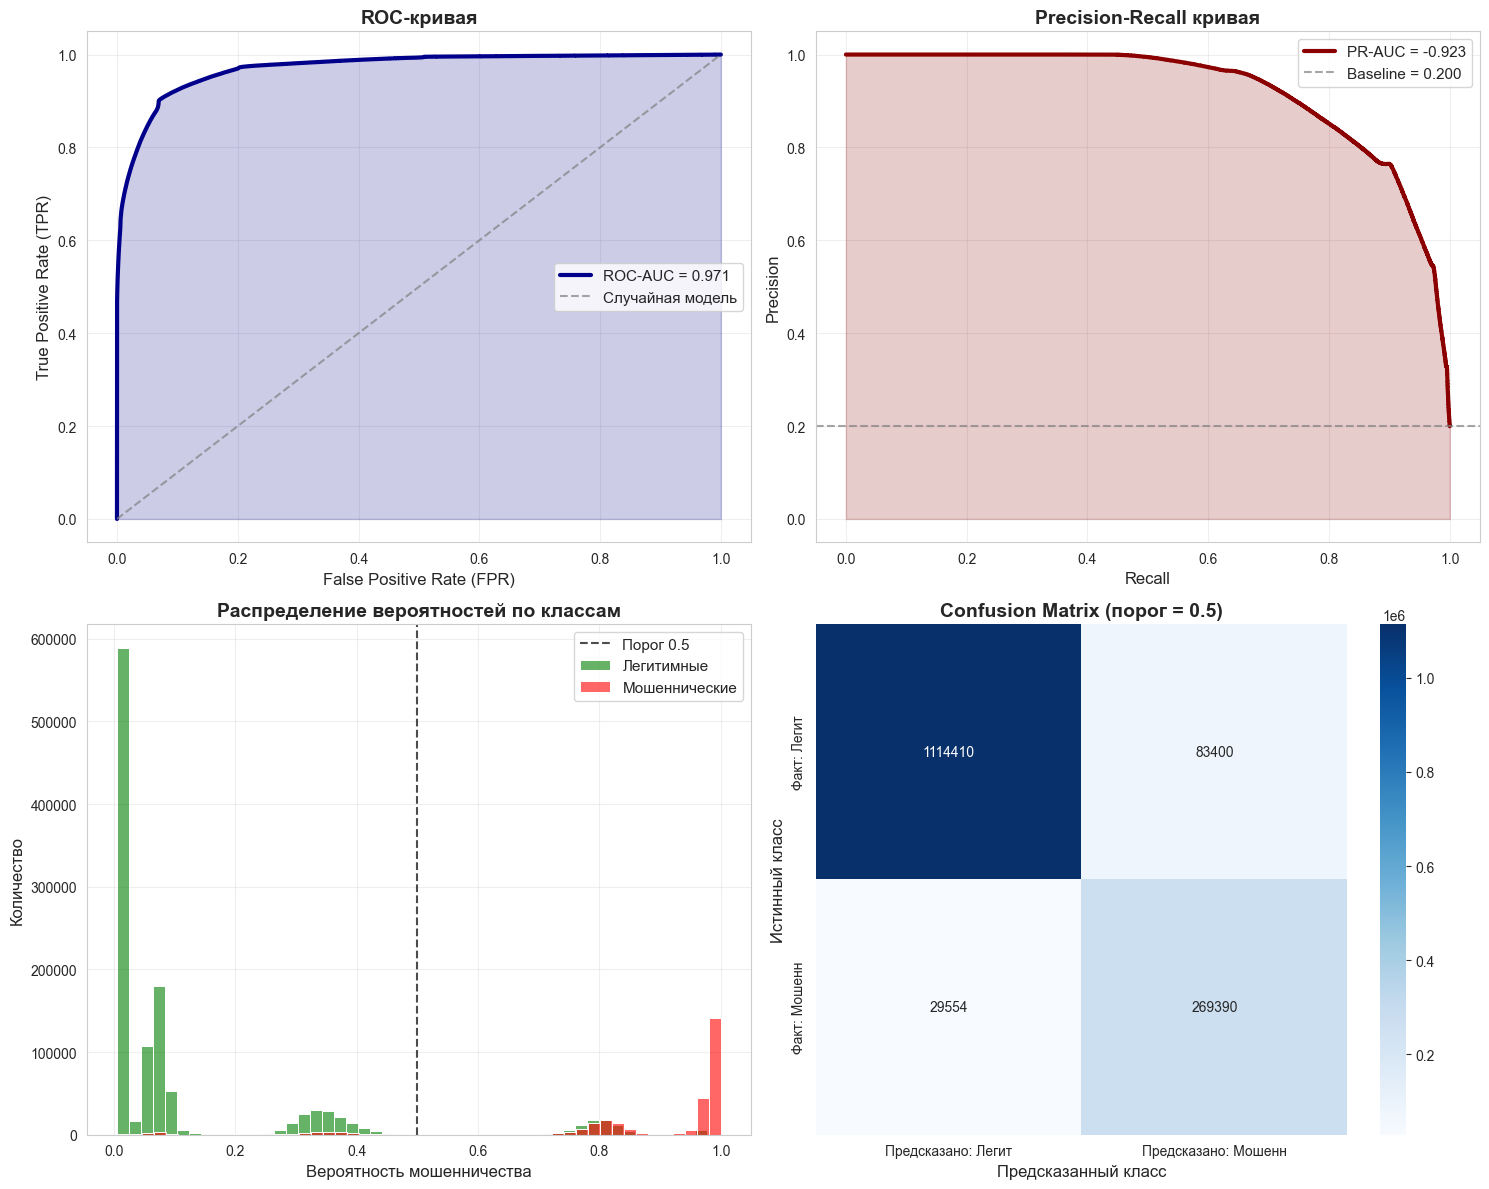

In [69]:

# Красивые кривые ROC и PR с дополнительной информацией
fpr, tpr, thr_roc = roc_curve(y_test, proba_test)
prec_curve, rec_curve, thr_pr = precision_recall_curve(y_test, proba_test)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. ROC кривая
ax1.plot(fpr, tpr, label=f'ROC-AUC = {roc:.3f}', linewidth=3, color='darkblue')
ax1.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.7, label='Случайная модель')
ax1.fill_between(fpr, tpr, alpha=0.2, color='darkblue')
ax1.set_xlabel('False Positive Rate (FPR)', fontsize=12)
ax1.set_ylabel('True Positive Rate (TPR)', fontsize=12)
ax1.set_title('ROC-кривая', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# 2. Precision-Recall кривая
baseline_precision = y_test.mean()
ax2.plot(rec_curve, prec_curve, linewidth=3, color='darkred', label=f'PR-AUC = {np.trapz(prec_curve, rec_curve):.3f}')
ax2.axhline(y=baseline_precision, color='gray', linestyle='--', alpha=0.7, 
           label=f'Baseline = {baseline_precision:.3f}')
ax2.fill_between(rec_curve, prec_curve, alpha=0.2, color='darkred')
ax2.set_xlabel('Recall', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('Precision-Recall кривая', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# 3. Распределение вероятностей по классам
proba_fraud = proba_test[y_test == 1]
proba_legit = proba_test[y_test == 0]

sns.histplot(proba_legit, bins=50, alpha=0.6, label='Легитимные', color='green', ax=ax3)
sns.histplot(proba_fraud, bins=50, alpha=0.6, label='Мошеннические', color='red', ax=ax3)
ax3.axvline(x=0.5, color='black', linestyle='--', alpha=0.7, label='Порог 0.5')
ax3.set_xlabel('Вероятность мошенничества', fontsize=12)
ax3.set_ylabel('Количество', fontsize=12)
ax3.set_title('Распределение вероятностей по классам', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

# 4. Confusion Matrix для порога 0.5
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred_test_default)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4,
           xticklabels=['Предсказано: Легит', 'Предсказано: Мошенн'],
           yticklabels=['Факт: Легит', 'Факт: Мошенн'])
ax4.set_title('Confusion Matrix (порог = 0.5)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Предсказанный класс', fontsize=12)
ax4.set_ylabel('Истинный класс', fontsize=12)

plt.tight_layout()
plt.show()


## 11) Важность признаков (коэффициенты логистической регрессии)

,feature,coefficient,abs_coefficient
49,device_Chip Reader,2.83,2.83
50,device_Chrome,1.87,1.87
52,device_Firefox,0.78,0.78
46,card_type_Platinum Credit,0.76,0.76
9,unique_merchants,0.67,0.67
21,country_Brazil,0.67,0.67
14,vendor_category_Gas,0.65,0.65
26,country_Mexico,0.65,0.65
47,card_type_Premium Debit,-0.62,0.62
28,country_Russia,0.60,0.60


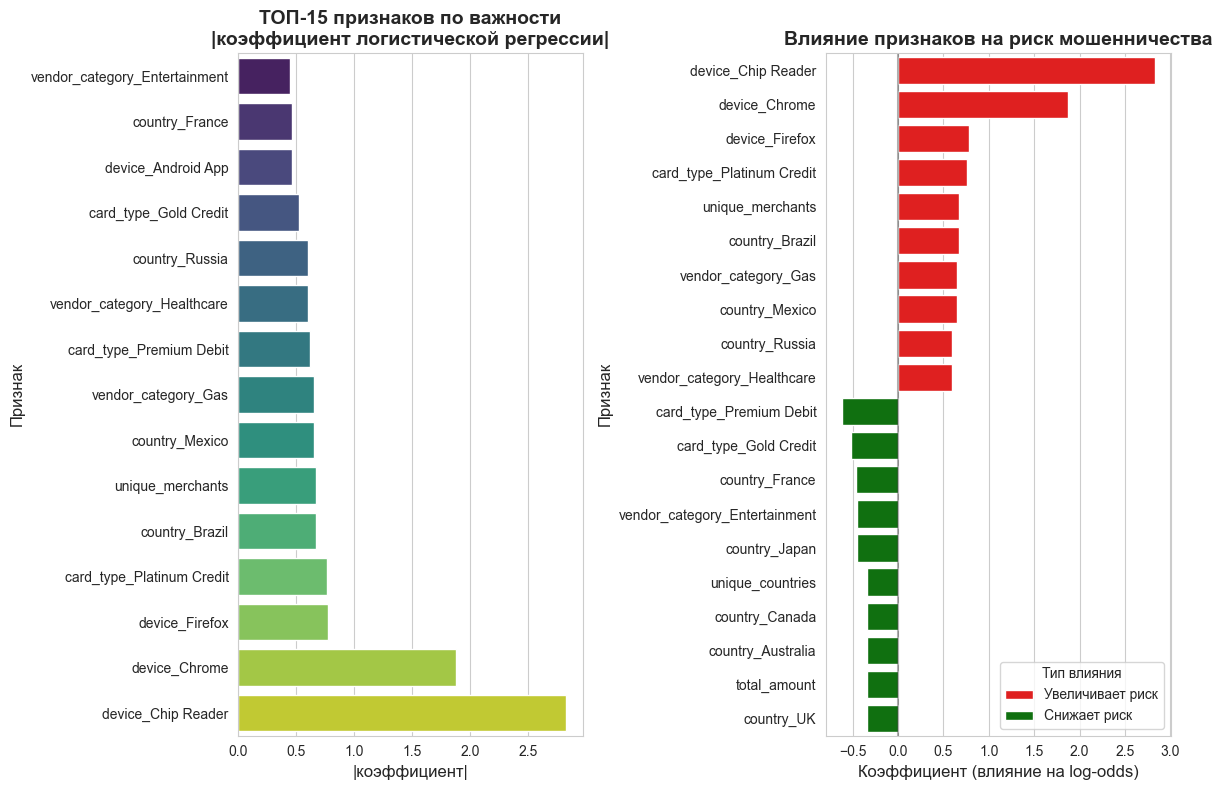

In [70]:

# Извлекаем имена фич после OneHot
ohe = pipe.named_steps["columntransformer"].named_transformers_["cat"]
num_scaler = pipe.named_steps["columntransformer"].named_transformers_["num"]
logreg = pipe.named_steps["logisticregression"]

cat_feature_names = []
if len(CATS) > 0:
    try:
        cat_feature_names = list(ohe.get_feature_names_out(CATS))
    except Exception:
        # совместимость со старыми версиями sklearn
        cat_feature_names = []
else:
    cat_feature_names = []

num_feature_names = NUMS

all_feature_names = num_feature_names + cat_feature_names
coefs = logreg.coef_.ravel()
imp = pd.DataFrame({"feature": all_feature_names, "coefficient": coefs})
imp["abs_coefficient"] = imp["coefficient"].abs()
imp = imp.sort_values("abs_coefficient", ascending=False)

display(imp.head(25))

# Красивая визуализация важности признаков
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=FIGSIZE_LARGE)

# 1. ТОП-15 по абсолютному значению коэффициента
top_features = imp.head(15).sort_values("abs_coefficient")
sns.barplot(data=top_features, y="feature", x="abs_coefficient", 
           palette='viridis', ax=ax1, orient='h')
ax1.set_title("ТОП-15 признаков по важности\n|коэффициент логистической регрессии|", 
             fontsize=14, fontweight='bold')
ax1.set_xlabel("|коэффициент|", fontsize=12)
ax1.set_ylabel("Признак", fontsize=12)

# 2. Положительные vs отрицательные коэффициенты
top_pos = imp[imp['coefficient'] > 0].head(10)
top_neg = imp[imp['coefficient'] < 0].head(10)

# Объединяем для визуализации
visualization_data = pd.concat([
    top_pos[['feature', 'coefficient']].assign(type='Увеличивает риск'),
    top_neg[['feature', 'coefficient']].assign(type='Снижает риск')
])

sns.barplot(data=visualization_data, y='feature', x='coefficient', 
           hue='type', palette=['red', 'green'], ax=ax2, orient='h')
ax2.set_title("Влияние признаков на риск мошенничества", fontsize=14, fontweight='bold')
ax2.set_xlabel("Коэффициент (влияние на log-odds)", fontsize=12)
ax2.set_ylabel("Признак", fontsize=12)
ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3)
ax2.legend(title='Тип влияния', fontsize=10)

plt.tight_layout()
plt.show()


## 12) Экономическая оценка и подбор порога

### 💡 Теория экономической модели

**Зачем нужен подбор порога?**  
Модель выдаёт вероятности от 0 до 1. Чтобы принять решение "блокировать транзакцию или нет", нужно выбрать **порог** (threshold). 

**Бизнес-подход:** порог, максимизирующий прибыль с учётом:
- 💰 **Экономии** от предотвращённого мошенничества (True Positive)
- 💸 **Потерь** от ложных срабатываний (False Positive) — недовольство клиентов, потерянные продажи

### 🧮 Формула расчёта прибыли

```
Прибыль = Предотвращённый_ущерб - Стоимость_ложных_тревог

где:
• Предотвращённый_ущерб = ∑(суммы TP транзакций) × PREVENTED_FRAUD_RATE
• Стоимость_ложных_тревог = количество FP × FP_COST
```

**Параметры модели:**
- `PREVENTED_FRAUD_RATE = 0.8` — доля ущерба, которую мы предотвращаем, поймав мошенническую транзакцию
- `FP_COST = 5.0` — стоимость одного ложного срабатывания (в валюте транзакций)

### ⚖️ Интерпретация результатов

Если лучший порог = 0.05 и прибыль = $28M, это означает:
- Модель рекомендует **очень низкий** порог (агрессивное блокирование)
- **Причины:** либо мошеннические транзакции имеют очень большие суммы, либо FP_COST занижен
- **Внимание:** такой порог даст много ложных срабатываний!


🔎 Лучший порог по прибыли: 0.05
💰 Ожидаемая прибыль на тестовой выборке: $28,307,468,820
📊 При этом пороге:
   • True Positives (поймано мошенничества): 296,834
   • False Positives (ложные тревоги): 578,362
   • False Negatives (пропущено мошенничества): 2,110
   • Precision: 0.339
   • Recall: 0.993

⚠️  ВАЖНЫЕ ПРИМЕЧАНИЯ:
   • Результат зависит от параметров FP_COST=5.0 и PREVENTED_FRAUD_RATE=0.8
   • Низкий порог означает много блокировок → проверьте, приемлемо ли это для бизнеса
   • Цифра прибыли — это оценка на исторических данных, не гарантия будущих результатов
   • Рекомендуется A/B тестирование на небольшой доле трафика перед полным внедрением


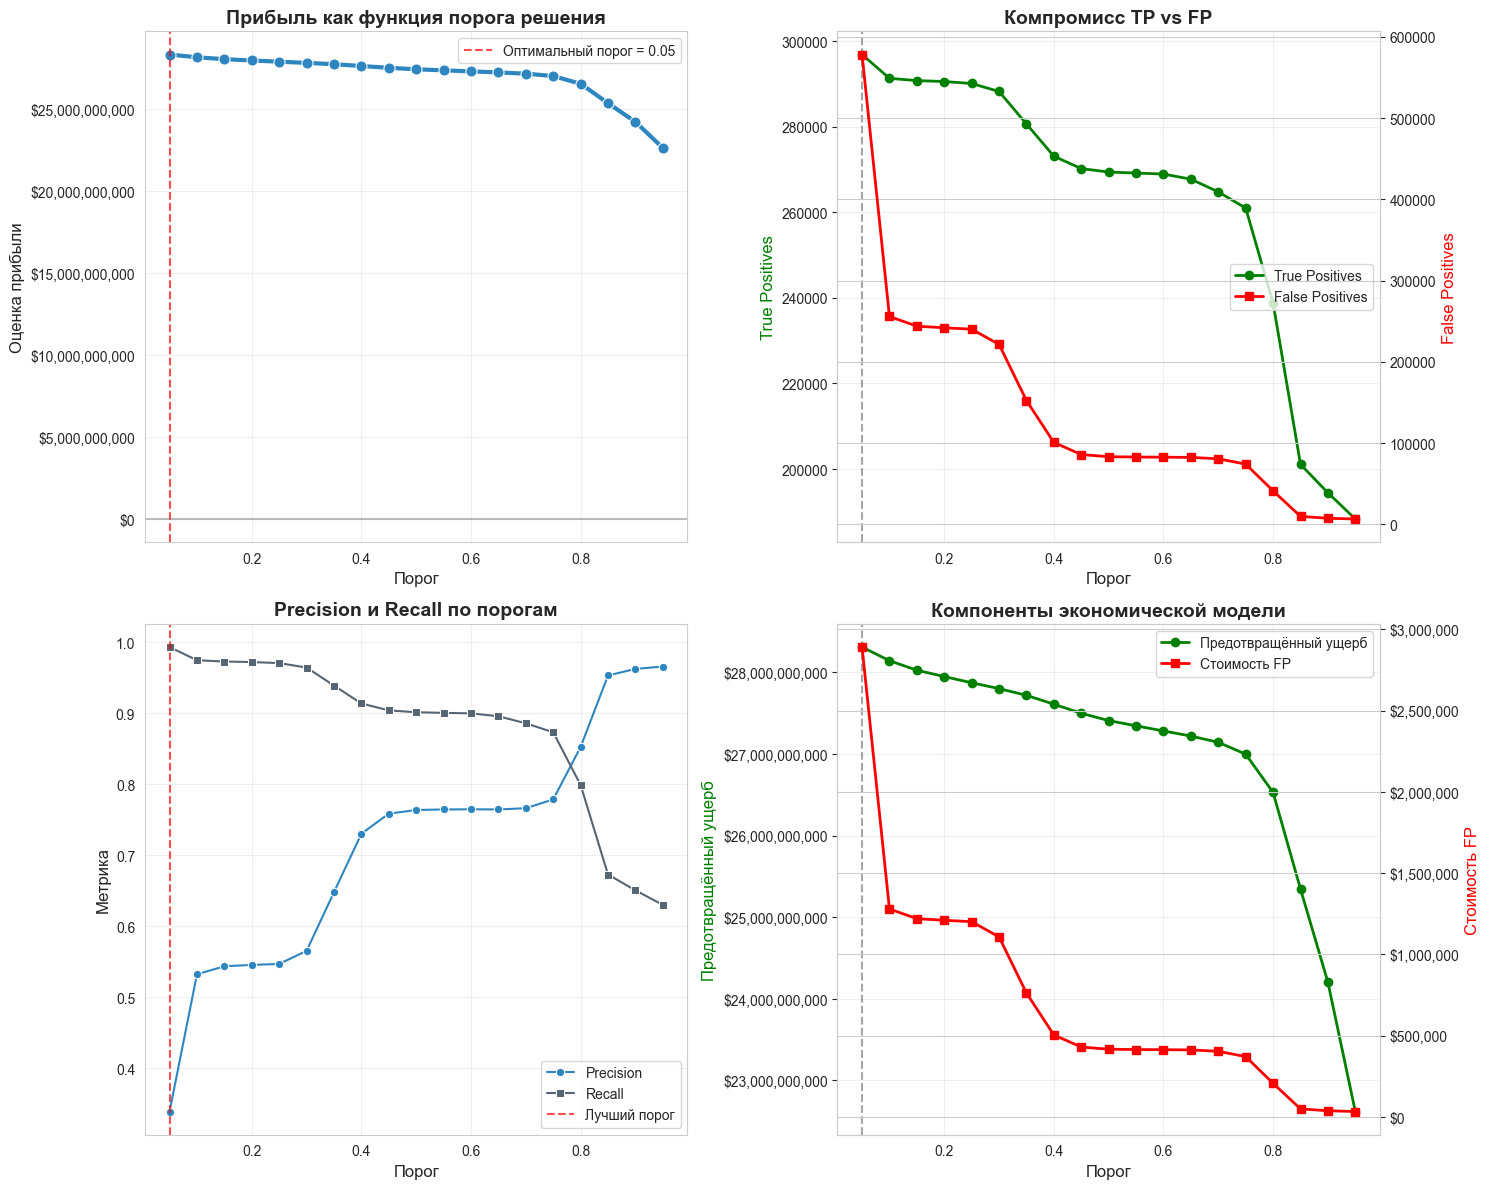

### 📋 Детализация по ключевым порогам

,Порог,Прибыль,ROI (%),TP,FP,Precision,Recall
0,0.05,"$28,307,468,820",978884.1,296834,578362,0.339,0.993
1,0.10,"$28,141,820,157",2198794.4,291281,255975,0.532,0.974
2,0.20,"$27,947,371,434",2309022.7,290529,242071,0.545,0.972
3,0.30,"$27,800,059,745",2508781.6,288204,221622,0.565,0.964
4,0.50,"$27,408,991,336",6572899.6,269390,83400,0.764,0.901


In [71]:

amount_col = _choose_column(df_model, ["amount"])
assert amount_col, "Для экономической модели требуется колонка 'amount'."

def profit_at_threshold(th, y_true, proba, amounts, fp_cost=FP_COST, prevented_rate=PREVENTED_FRAUD_RATE):
    pred = (proba >= th).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
    # прибыль = экономия от пойманного мошенничества - стоимость ложноположительных
    saved = amounts[(pred==1) & (y_true==1)].sum() * prevented_rate
    cost = fp * fp_cost
    return saved - cost, tp, fp, fn, tn

thresholds = np.linspace(0.05, 0.95, 19)
thresholds = np.sort(thresholds)  # Сортируем по возрастанию
profits, tps, fps, fns, tns = [], [], [], [], []

# Отберём amounts для теста (выравнивание индексов на случай перестановок)
test_idx = X_test.index
amounts_test = df_model.loc[test_idx, amount_col]

for th in thresholds:
    p, tp, fp, fn, tn = profit_at_threshold(th, y_test, proba_test, amounts_test)
    profits.append(p); tps.append(tp); fps.append(fp); fns.append(fn); tns.append(tn)

best_i = int(np.argmax(profits))
best_th = float(thresholds[best_i])
best_profit = float(profits[best_i])

print(f"🔎 Лучший порог по прибыли: {best_th:.2f}")
print(f"💰 Ожидаемая прибыль на тестовой выборке: ${best_profit:,.0f}")
print(f"📊 При этом пороге:")
print(f"   • True Positives (поймано мошенничества): {tps[best_i]:,}")
print(f"   • False Positives (ложные тревоги): {fps[best_i]:,}")
print(f"   • False Negatives (пропущено мошенничества): {fns[best_i]:,}")
print(f"   • Precision: {tps[best_i]/(tps[best_i]+fps[best_i]):.3f}")
print(f"   • Recall: {tps[best_i]/(tps[best_i]+fns[best_i]):.3f}")
print()
print("⚠️  ВАЖНЫЕ ПРИМЕЧАНИЯ:")
print(f"   • Результат зависит от параметров FP_COST={FP_COST} и PREVENTED_FRAUD_RATE={PREVENTED_FRAUD_RATE}")
print("   • Низкий порог означает много блокировок → проверьте, приемлемо ли это для бизнеса")
print("   • Цифра прибыли — это оценка на исторических данных, не гарантия будущих результатов")
print("   • Рекомендуется A/B тестирование на небольшой доле трафика перед полным внедрением")

# Улучшенная визуализация экономической модели
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. График прибыли
sns.lineplot(x=thresholds, y=profits, marker='o', linewidth=3, markersize=8, ax=ax1)
ax1.axvline(best_th, linestyle='--', color='red', alpha=0.7, 
           label=f'Оптимальный порог = {best_th:.2f}')
ax1.axhline(0, linestyle='-', color='gray', alpha=0.5)
ax1.set_title('Прибыль как функция порога решения', fontsize=14, fontweight='bold')
ax1.set_xlabel('Порог', fontsize=12)
ax1.set_ylabel('Оценка прибыли', fontsize=12)
ax1.yaxis.set_major_formatter(FuncFormatter(_fmt_money))
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Количество TP и FP
ax2_twin = ax2.twinx()
line1 = ax2.plot(thresholds, tps, 'g-o', label='True Positives', linewidth=2, markersize=6)
line2 = ax2_twin.plot(thresholds, fps, 'r-s', label='False Positives', linewidth=2, markersize=6)
ax2.axvline(best_th, linestyle='--', color='gray', alpha=0.7)
ax2.set_xlabel('Порог', fontsize=12)
ax2.set_ylabel('True Positives', color='green', fontsize=12)
ax2_twin.set_ylabel('False Positives', color='red', fontsize=12)
ax2.set_title('Компромисс TP vs FP', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
# Объединяем легенды
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc='center right')

# 3. Precision и Recall
precisions = [tp/(tp+fp) if (tp+fp) > 0 else 0 for tp, fp in zip(tps, fps)]
recalls = [tp/(tp+fn) if (tp+fn) > 0 else 0 for tp, fn in zip(tps, fns)]

sns.lineplot(x=thresholds, y=precisions, label='Precision', marker='o', ax=ax3)
sns.lineplot(x=thresholds, y=recalls, label='Recall', marker='s', ax=ax3)
ax3.axvline(best_th, linestyle='--', color='red', alpha=0.7, label=f'Лучший порог')
ax3.set_title('Precision и Recall по порогам', fontsize=14, fontweight='bold')
ax3.set_xlabel('Порог', fontsize=12)
ax3.set_ylabel('Метрика', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Экономический анализ: компоненты прибыли
saved_amounts = [amounts_test[(proba_test >= th) & (y_test == 1)].sum() * PREVENTED_FRAUD_RATE 
                for th in thresholds]
costs = [fp * FP_COST for fp in fps]

ax4_twin = ax4.twinx()
line1 = ax4.plot(thresholds, saved_amounts, 'g-o', label='Предотвращённый ущерб', linewidth=2)
line2 = ax4_twin.plot(thresholds, costs, 'r-s', label='Стоимость FP', linewidth=2)
ax4.axvline(best_th, linestyle='--', color='gray', alpha=0.7)
ax4.set_xlabel('Порог', fontsize=12)
ax4.set_ylabel('Предотвращённый ущерб', color='green', fontsize=12)
ax4_twin.set_ylabel('Стоимость FP', color='red', fontsize=12)
ax4.set_title('Компоненты экономической модели', fontsize=14, fontweight='bold')
ax4.yaxis.set_major_formatter(FuncFormatter(_fmt_money))
ax4_twin.yaxis.set_major_formatter(FuncFormatter(_fmt_money))
ax4.grid(True, alpha=0.3)
# Объединяем легенды
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax4.legend(lines, labels, loc='upper right')

plt.tight_layout()
plt.show()

# Дополнительная таблица с детализацией по порогам
show_md("### 📋 Детализация по ключевым порогам")
key_thresholds = sorted([0.1, 0.2, 0.3, 0.5, best_th])  # Сортируем по возрастанию
results_table = []
for th in key_thresholds:
    idx = np.argmin(np.abs(thresholds - th))
    if idx < len(profits):
        # Расчет ROI: (прибыль / инвестиции) * 100
        investment = fps[idx] * FP_COST  # Стоимость ложных тревог как инвестиция в безопасность
        roi = (profits[idx] / investment * 100) if investment > 0 else 0
        
        results_table.append({
            'Порог': f"{th:.2f}",
            'Прибыль': f"${profits[idx]:,.0f}",
            'ROI (%)': f"{roi:.1f}",
            'TP': tps[idx],
            'FP': fps[idx],
            'Precision': f"{tps[idx]/(tps[idx]+fps[idx]):.3f}" if (tps[idx]+fps[idx]) > 0 else "0.000",
            'Recall': f"{tps[idx]/(tps[idx]+fns[idx]):.3f}" if (tps[idx]+fns[idx]) > 0 else "0.000"
        })

results_df = pd.DataFrame(results_table)
display(results_df)


## 13) Итоговое резюме для стейкхолдеров

In [72]:
total_fraud_amount = df_model.loc[df_model["is_fraud"]==1, amount_col].sum()
avg_fraud_amount = df_model.loc[df_model["is_fraud"]==1, amount_col].mean()
fraud_rate = df_model["is_fraud"].mean()

summary_md = f'''
### 📌 Краткие выводы
- Объём данных (после подготовки): **{len(df_model):,}** записей, период: **{df["timestamp"].min()} → {df["timestamp"].max()}**
- Уровень мошенничества: **{fraud_rate:.2%}**
- ROC-AUC модели (holdout): **{roc:.3f}**
- Рекомендуемый порог (по прибыли): **{best_th:.2f}**
- Средняя сумма мошеннической транзакции: **${avg_fraud_amount:,.0f}**
- Совокупный объём мошенничества в данных: **${total_fraud_amount:,.0f}**

### 🎯 Рекомендации по внедрению

#### 📈 Модель и пороги
1. **Калибровка порога**: Текущий оптимальный порог {best_th:.2f} может быть слишком агрессивным
   - Рекомендуется начать с более консервативного порога (0.3-0.5) для пилота
   - Постепенно снижать порог по мере накопления опыта

2. **Адаптивные пороги**: Рассмотреть разные пороги для разных сегментов:
   - Международные операции: более низкий порог
   - Ночные часы: более низкий порог  
   - VIP-клиенты: более высокий порог

#### 🔄 Процесс внедрения
3. **Поэтапное развёртывание**:
   - Фаза 1: Shadow mode (модель работает, но не блокирует)
   - Фаза 2: Пилот на 5-10% трафика с консервативным порогом
   - Фаза 3: Постепенное увеличение охвата при подтверждении эффективности

4. **Мониторинг и контроль**:
   - Ежедневный мониторинг Precision/Recall
   - Отслеживание жалоб клиентов на ложные блокировки
   - A/B тестирование разных порогов

#### ⚠️ Риски и митигация
5. **Основные риски**:
   - Высокий FP rate → недовольство клиентов
   - Drift модели → снижение качества со временем
   - Адаптация мошенников → обход модели

6. **План митигации**:
   - Еженедельный пересчёт метрик на новых данных
   - Ежемесячное переобучение модели
   - Система быстрого отключения при аномалиях
'''
show_md(summary_md)



### 📌 Краткие выводы
- Объём данных (после подготовки): **7,483,766** записей, период: **2024-09-30 00:00:01.034820 → 2024-10-30 23:59:59.101885**
- Уровень мошенничества: **19.97%**
- ROC-AUC модели (holdout): **0.971**
- Рекомендуемый порог (по прибыли): **0.05**
- Средняя сумма мошеннической транзакции: **$118,774**
- Совокупный объём мошенничества в данных: **$177,533,141,479**

### 🎯 Рекомендации по внедрению

#### 📈 Модель и пороги
1. **Калибровка порога**: Текущий оптимальный порог 0.05 может быть слишком агрессивным
   - Рекомендуется начать с более консервативного порога (0.3-0.5) для пилота
   - Постепенно снижать порог по мере накопления опыта

2. **Адаптивные пороги**: Рассмотреть разные пороги для разных сегментов:
   - Международные операции: более низкий порог
   - Ночные часы: более низкий порог  
   - VIP-клиенты: более высокий порог

#### 🔄 Процесс внедрения
3. **Поэтапное развёртывание**:
   - Фаза 1: Shadow mode (модель работает, но не блокирует)
   - Фаза 2: Пилот на 5-10% трафика с консервативным порогом
   - Фаза 3: Постепенное увеличение охвата при подтверждении эффективности

4. **Мониторинг и контроль**:
   - Ежедневный мониторинг Precision/Recall
   - Отслеживание жалоб клиентов на ложные блокировки
   - A/B тестирование разных порогов

#### ⚠️ Риски и митигация
5. **Основные риски**:
   - Высокий FP rate → недовольство клиентов
   - Drift модели → снижение качества со временем
   - Адаптация мошенников → обход модели

6. **План митигации**:
   - Еженедельный пересчёт метрик на новых данных
   - Ежемесячное переобучение модели
   - Система быстрого отключения при аномалиях


## 14) Экспорт артефактов (модель, метрики)

In [73]:

ART_DIR = Path("artifacts"); ART_DIR.mkdir(exist_ok=True)
joblib.dump(pipe, ART_DIR / "fraud_logreg_pipeline.joblib")

metrics = {
    "roc_auc": float(roc),
    "accuracy@0.5": float(acc),
    "precision@0.5": float(prec),
    "recall@0.5": float(rec),
    "best_threshold": float(best_th),
}
with open(ART_DIR / "metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("💾 Сохранены артефакты:")
print("   • artifacts/fraud_logreg_pipeline.joblib - обученная модель")
print("   • artifacts/metrics.json - основные метрики качества")
print()
print("🚀 Модель готова к использованию!")
print("📖 Для загрузки: pipeline = joblib.load('artifacts/fraud_logreg_pipeline.joblib')")
print("🔮 Для предсказания: proba = pipeline.predict_proba(X_new)[:, 1]")


💾 Сохранены артефакты:
   • artifacts/fraud_logreg_pipeline.joblib - обученная модель
   • artifacts/metrics.json - основные метрики качества

🚀 Модель готова к использованию!
📖 Для загрузки: pipeline = joblib.load('artifacts/fraud_logreg_pipeline.joblib')
🔮 Для предсказания: proba = pipeline.predict_proba(X_new)[:, 1]
